In [3]:
import cv2 as cv 
import numpy as np 
import matplotlib.pyplot as plt 
import pywt
from skimage.restoration import estimate_sigma
from time import sleep
from os.path import join
plt.rcParams.update({
    'figure.figsize': (20, 20)
})

In [11]:
def img_plot( img, fig= plt  ):
    fig.imshow( img , cmap=plt.cm.gray  )
    fig.xticks([])
    fig.yticks([])
    
def img_plot_add( img, ax ):
    ax.imshow( img, cmap=plt.cm.gray )


In [12]:
def noise( img, std ):
    row, col = img.shape
    mean = 0
    gauss = np.random.normal( mean, std ** 2, (row, col) )
    gauss = gauss.reshape( row, col )
    img_noise = img + gauss 
    return img_noise / np.max( img_noise )

In [13]:
def threshold_universal( img, len_data ):
    return estimate_sigma( img )  * np.sqrt( 2*np.log10( len_data ) )

In [43]:
def filter_noise_wavelet(img, wavelet_name='haar', threshold_func = threshold_universal):
    row, col = img.shape
    len_data = row * col 
    w = pywt.Wavelet( wavelet_name )
    level = pywt.dwt_max_level( data_len= len_data, filter_len=w.dec_len )
    coeff2 = pywt.wavedec2( img, w, level=level )


    threshold = threshold_func( img, len_data )
    arr, coeff_slices = pywt.coeffs_to_array(coeff2)



    coeff2[1:] = [ [ pywt.threshold( j, value=threshold, mode='hard' ) for j in i ] for i in coeff2[1:] ]

    #coeff2 = pywt.array_to_coeffs( arr, coeff_slices, 'wavedec2' )

    img_rec = pywt.waverec2( coeff2, w )
    
    return img_rec

In [44]:
def add_noise_video( video_path, video_path_noise ):
    cap = cv.VideoCapture('Inputs/video_01.mp4')
    fourcc = cv.VideoWriter_fourcc(*"MJPG")
    out = cv.VideoWriter('Outputs/noise_03.avi', fourcc , 20.0, (300, 300), 0)
    
    while(True):
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        gray = noise( gray / 255 , .2 )
        gray =  cv.resize( gray*255, (300, 300) ) 
        gray = gray.astype( np.uint8 )
        out.write( gray )
        cv.imshow( 'frame' ,gray )

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv.destroyAllWindows()
    
add_noise_video('1', '2')

In [45]:
def filter_video_wavelet( path_video, path_filter ):
    cap = cv.VideoCapture( 'Outputs/noise_03.avi' )
    fourcc = cv.VideoWriter_fourcc( *"MJPG" )
    out = cv.VideoWriter( 'Outputs/denoise_01.avi', fourcc, 30.0, (300, 300), 0 )
    
    while( True ):
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame = cv.cvtColor( frame, cv.COLOR_BGR2GRAY ) / 255
        
        filter_img = filter_noise_wavelet( frame )

        
        
        filter_img = filter_img * 255
        filter_img = filter_img.astype( np.uint8 )
        filter_img = cv.resize( filter_img, (300, 300) )
        cv.imshow( 'frame', filter_img )
            
        out.write( filter_img )
        if( cv.waitKey(1) == ord('q') ):
            break
    cap.release()
    out.release()
    cv.destroyAllWindows()

In [46]:
filter_video_wavelet('1', '2')

/home/lautaro/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 16 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


## Cambiando el umbral

In [47]:
def add_noise( name_image, std ):
    img = cv.imread( join( 'Inputs', name_image ) )
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cv.imwrite( 'Outputs/face_01.jpg', img )
    img_noise = noise( img/255, std )  
    return img_noise

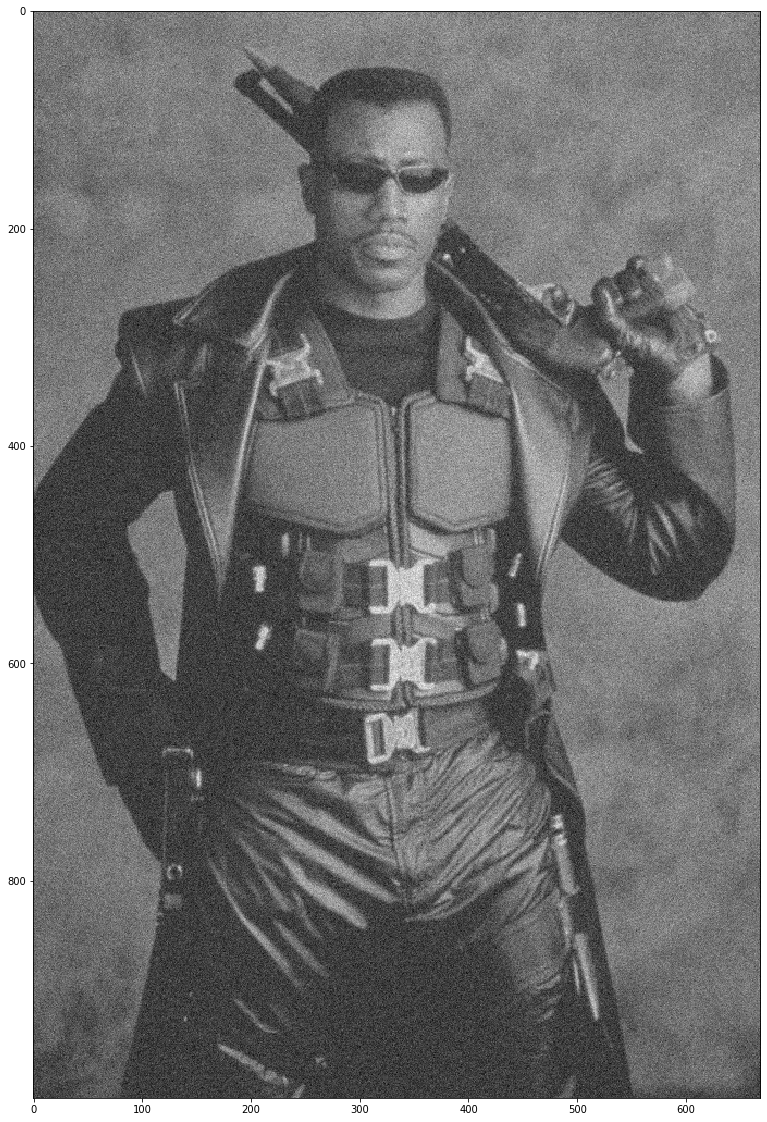

In [51]:
blade_noise = add_noise( 'face_01.jpg', .3 )
blade_noise -= np.min( blade_noise )
blade_noise /= np.max( blade_noise )
plt.imshow( blade_noise, cmap=plt.cm.gray, vmin=0, vmax=1 )

True

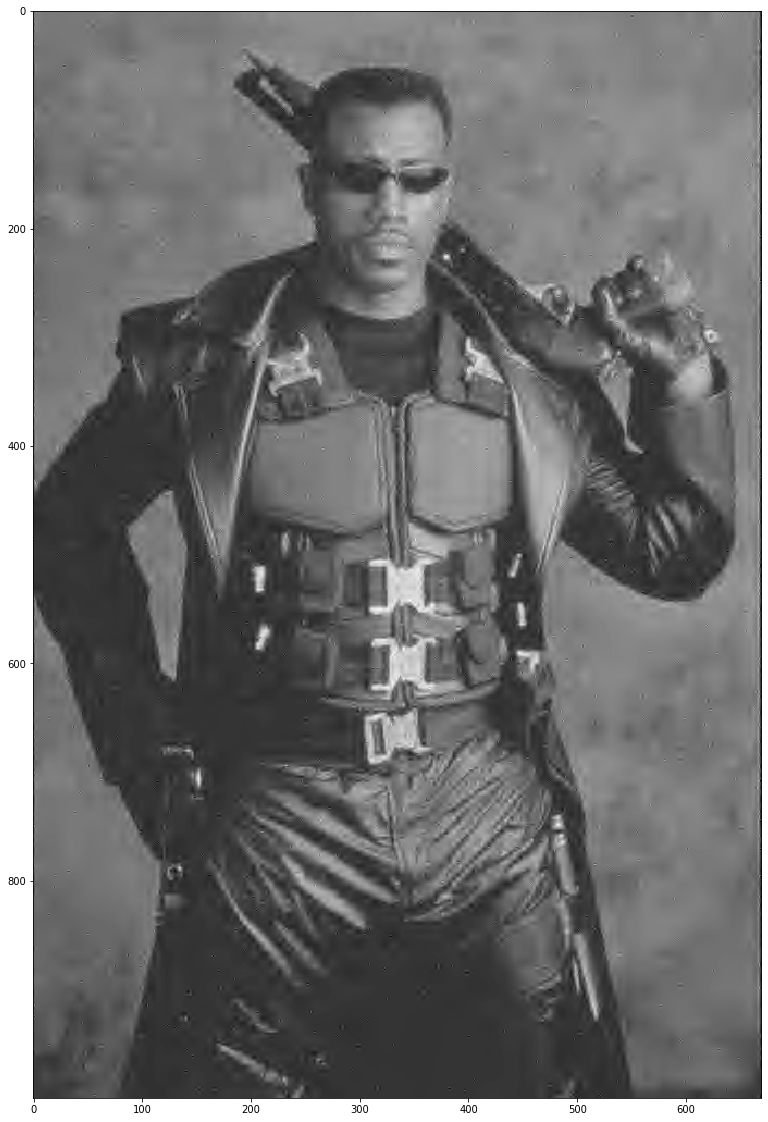

In [52]:
blade_desnoise =  filter_noise_wavelet( blade_noise, wavelet_name='sym4' )
blade_desnoise -= np.min( blade_desnoise )
blade_desnoise /= np.max( blade_desnoise )
plt.imshow( blade_desnoise, cmap=plt.cm.gray, vmin=0, vmax=1 )

blade_desnoise *= 255 
blade_desnoise = blade_desnoise.astype( np.uint8 )

cv.imwrite( 'Outputs/face_02.jpg', blade_desnoise )



In [62]:
def bayes_denoise( img, wavelet_name='haar' ):
    row, col = img.shape
    len_data = row * col 
    w = pywt.Wavelet( wavelet_name )
    level = pywt.dwt_max_level( data_len= len_data, filter_len=w.dec_len )
    coeff2 = pywt.wavedec2( img, w, level=level )

    
    arr, coeff_slices = pywt.coeffs_to_array(coeff2)

    (H, L, V ) = coeff2[1]
    rows, cols = H.shape
    sigma = estimate_sigma( img ) ** 2
    
    sigmaY = np.sum( H * H ) / ( rows * cols ) 

    sigmaX = np.sqrt( np.max( [ sigmaY - sigma  , 0 ]  ) )
    
    if( sigmaX <= 0 ):
        threshold = np.max( np.abs( H ) )
    else:
        threshold = sigma / sigmaX
    

    coeff2[1:] = [ [ pywt.threshold( j, value=threshold, mode='hard' ) for j in i ] for i in coeff2[1:] ]


    #coeff2 = pywt.array_to_coeffs( arr, coeff_slices, 'wavedec2' )

    img_rec = pywt.waverec2( coeff2, w )
    
    return img_rec

In [63]:
blade_desnoise_bayes = bayes_denoise( blade_noise, wavelet_name='sym4' )

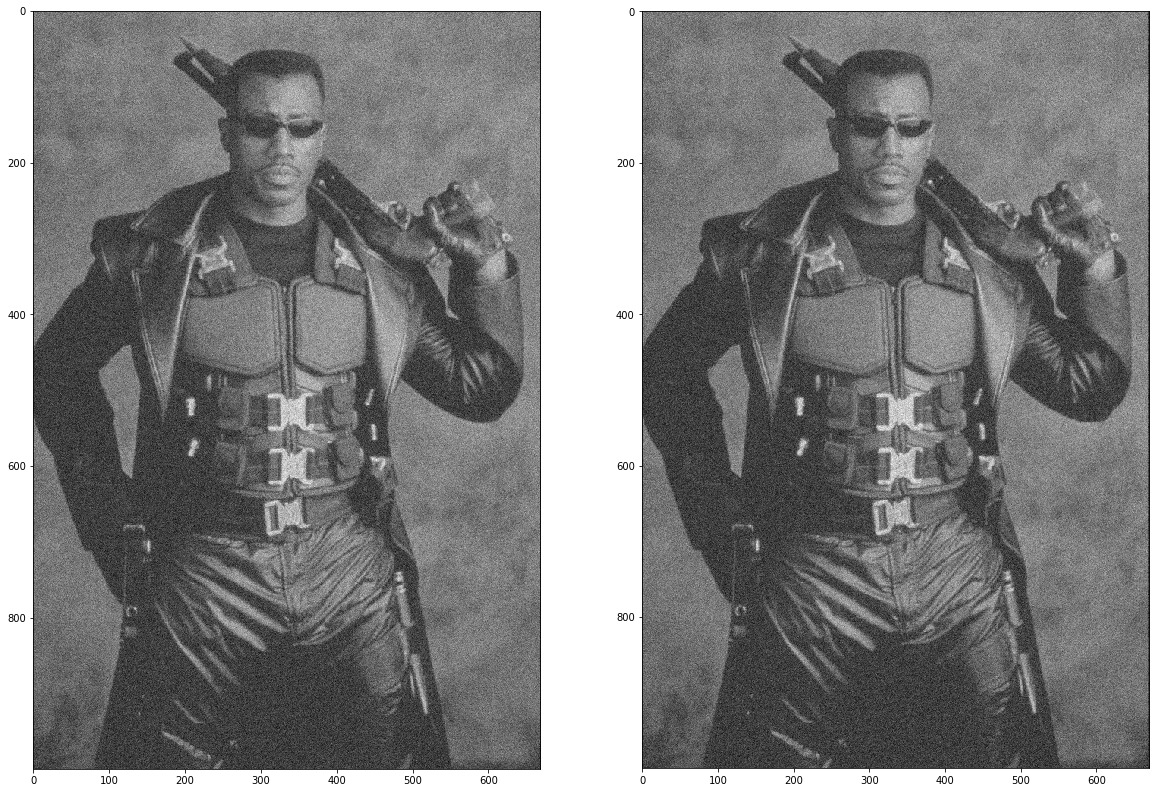

In [64]:
fig, axs = plt.subplots( 1, 2, figsize = ( 20, 40 ) )
axs[0].imshow( blade_noise, cmap=plt.cm.gray, vmin=0, vmax=1 )
axs[1].imshow( blade_desnoise_bayes, cmap=plt.cm.gray, vmin=0, vmax=1 )
plt.savefig( './blade-comparation.png' )

In [57]:
estimate_sigma( blade_noise ), estimate_sigma( blade_desnoise_bayes )

(0.05682974282252747, 0.05661383800438608)